# original

https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

# special

- almost all are one hot encoding
- many features
- **Sex one hot encoding**
- **Pclass one hot encoding**
- **Family size one hot encoding**
- **Ticket_Lett one hot encoding :first letter of each ticket**
- 

# score

cv score for all training set is not so high. 0.8383838383838383
it is below my current best score 2018/04/01.


# columns

Index(['Survived', 'Age', 'Fare', 'Name_Len', 'Age_Null_Flag',
       'Cabin_num_(1.999, 28.667]', 'Cabin_num_(28.667, 65.667]',
       'Cabin_num_(65.667, 148.0]', 'Ticket_Len', 'Pclass_3', 'Pclass_1',
       'Pclass_2', 'Sex_male', 'Sex_female', 'Embarked_S', 'Embarked_C',
       'Embarked_Q', 'Ticket_Lett_A', 'Ticket_Lett_P', 'Ticket_Lett_S',
       'Ticket_Lett_1', 'Ticket_Lett_3', 'Ticket_Lett_2', 'Ticket_Lett_C',
       'Ticket_Lett_Low_ticket', 'Ticket_Lett_Other_ticket', 'Cabin_Letter_n',
       'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_G', 'Cabin_Letter_D',
       'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F', 'Name_Title_Mr.',
       'Name_Title_Mrs.', 'Name_Title_Miss.', 'Name_Title_Master.',
       'Name_Title_Rev.', 'Name_Title_Dr.', 'Name_Title_Ms.',
       'Name_Title_Col.', 'Fam_Size_Nuclear', 'Fam_Size_Solo', 'Fam_Size_Big'],
      dtype='object')

# else

	variable	importance
12	Sex_female	0.111215
11	Sex_male	0.109769
33	Name_Title_Mr.	0.109746
1	Fare	0.088209
2	Name_Len	0.087904
0	Age	0.078651
8	Pclass_3	0.043268
35	Name_Title_Miss.	0.031292
7	Ticket_Len	0.031079
34	Name_Title_Mrs.	0.028852
25	Cabin_Letter_n	0.027893
43	Fam_Size_Big	0.025199
41	Fam_Size_Nuclear	0.022704
9	Pclass_1	0.021810
19	Ticket_Lett_1	0.017999
20	Ticket_Lett_3	0.012902
10	Pclass_2	0.012345
36	Name_Title_Master.	0.012098
23	Ticket_Lett_Low_ticket	0.011723
13	Embarked_S	0.011546



In [32]:
import time

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# train, test, validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier


# scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

# decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

# feature engineering
from sklearn.preprocessing import PolynomialFeatures

# feature selection
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

In [33]:
# Utility function to report best scores
def report(results, n_top=3):
    """Utility function to report best scores
    """
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Rank: {0}".format(i))
            print("Score: {0:f} (std: {1:f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Pars: {0}".format(results['params'][candidate]))
            print("")
            

def report2(results, n_top=3):
    """Utility function to report best scores
    """
    print("Rank|Score(std)|Params", list(results['params'][0].keys()))
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("{0}|".format(i), end="")
            print("{0:f}(std:{1:f})|".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]), end="")
            print("{0}".format(list(results['params'][candidate].values())))

In [34]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def names(train, test):
    for i in [train, test]:
        i['Name_Len'] = i['Name'].apply(lambda x: len(x))
        i['Name_Title'] = i['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
        del i['Name']
    return train, test

def age_impute(train, test):
    for i in [train, test]:
        i['Age_Null_Flag'] = i['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
        data = train.groupby(['Name_Title', 'Pclass'])['Age']
        i['Age'] = data.transform(lambda x: x.fillna(x.mean()))
    return train, test


def fam_size(train, test):
    for i in [train, test]:
        i['Fam_Size'] = np.where((i['SibSp']+i['Parch']) == 0 , 'Solo',
                           np.where((i['SibSp']+i['Parch']) <= 3,'Nuclear', 'Big'))
        del i['SibSp']
        del i['Parch']
    return train, test


def ticket_grouped(train, test):
    for i in [train, test]:
        i['Ticket_Lett'] = i['Ticket'].apply(lambda x: str(x)[0])
        i['Ticket_Lett'] = i['Ticket_Lett'].apply(lambda x: str(x))
        i['Ticket_Lett'] = np.where((i['Ticket_Lett']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), i['Ticket_Lett'],
                                   np.where((i['Ticket_Lett']).isin(['W', '4', '7', '6', 'L', '5', '8']),
                                            'Low_ticket', 'Other_ticket'))
        i['Ticket_Len'] = i['Ticket'].apply(lambda x: len(x))
        del i['Ticket']
    return train, test


def cabin(train, test):
    for i in [train, test]:
        i['Cabin_Letter'] = i['Cabin'].apply(lambda x: str(x)[0])
        del i['Cabin']
    return train, test

def cabin_num(train, test):
    for i in [train, test]:
        i['Cabin_num1'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
        i['Cabin_num1'].replace('an', np.NaN, inplace = True)
        i['Cabin_num1'] = i['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
        i['Cabin_num'] = pd.qcut(train['Cabin_num1'],3)
    train = pd.concat((train, pd.get_dummies(train['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    test = pd.concat((test, pd.get_dummies(test['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    del train['Cabin_num']
    del test['Cabin_num']
    del train['Cabin_num1']
    del test['Cabin_num1']
    return train, test


def embarked_impute(train, test):
    for i in [train, test]:
        i['Embarked'] = i['Embarked'].fillna('S')
    return train, test

def dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett', 'Cabin_Letter', 'Name_Title', 'Fam_Size']):
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test

def drop(train, test, bye = ['PassengerId']):
    for i in [train, test]:
        for z in bye:
            del i[z]
    return train, test


train = pd.read_csv(os.path.join('../input', 'train.csv'))
test = pd.read_csv(os.path.join('../input', 'test.csv'))
train, test = names(train, test)
train, test = age_impute(train, test)
train, test = cabin_num(train, test)
train, test = cabin(train, test)
train, test = embarked_impute(train, test)
train, test = fam_size(train, test)
test['Fare'].fillna(train['Fare'].mean(), inplace = True)
train, test = ticket_grouped(train, test)
train, test = dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = drop(train, test)

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=3)

param_grid = { "criterion" : ["gini", "entropy"], 
              "min_samples_leaf" : [1, 5, 10], 
              "min_samples_split" : [2, 4, 10, 12, 16],
              "n_estimators": [50, 100, 400, 700, 1000]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', 
                  cv=3, n_jobs=6, verbose=1)

gs = gs.fit(train.iloc[:, 1:], train.iloc[:, 0])

print(gs.best_score_)
print(gs.best_params_)
print(gs.cv_results_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   36.3s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 450 out of 450 | elapsed:  1.5min finished


0.8383838383838383
{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 700}
{'mean_fit_time': array([0.23539925, 0.33712943, 0.80466318, 1.52326751, 2.00184425,
       0.17175182, 0.22084697, 0.78224889, 1.39152304, 1.83824134,
       0.16723434, 0.20508679, 0.84553933, 1.32509335, 1.77881598,
       0.17081602, 0.20941639, 0.79459302, 1.30329251, 1.80821745,
       0.16890256, 0.20205522, 0.72184642, 1.33989016, 1.7373414 ,
       0.16834307, 0.2179021 , 0.77509522, 1.35552971, 1.68355417,
       0.15951784, 0.20614894, 0.78354462, 1.25358796, 1.88760201,
       0.18347692, 0.20698452, 0.74847523, 1.32237927, 1.81297882,
       0.17015107, 0.21768355, 0.76765545, 1.17944884, 1.83665284,
       0.16612903, 0.21771232, 0.71689423, 1.36948991, 1.78488994,
       0.17578101, 0.19873563, 0.7647051 , 1.32978241, 1.73306211,
       0.16512211, 0.22019458, 0.74051412, 1.25883142, 1.77190924,
       0.15898236, 0.18706004, 0.80248117, 1.32517234, 1.77281531,
 

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(train.iloc[:, 1:], train.iloc[:, 0])
print("%.4f" % rf.oob_score_)

0.8294


----

In [37]:
print("best parameters:", gs.best_params_)
print("Mean cross-validated score of the best_estimator: ", gs.best_score_)
print("")
report2(gs.cv_results_, n_top=10)

best parameters: {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 700}
Mean cross-validated score of the best_estimator:  0.8383838383838383

Rank|Score(std)|Params ['criterion', 'min_samples_leaf', 'min_samples_split', 'n_estimators']
1|0.838384(std:0.018027)|['gini', 1, 10, 700]
1|0.838384(std:0.016495)|['gini', 1, 10, 1000]
1|0.838384(std:0.009912)|['entropy', 1, 4, 400]
1|0.838384(std:0.009912)|['entropy', 1, 12, 50]
5|0.837262(std:0.013561)|['gini', 1, 4, 50]
5|0.837262(std:0.004199)|['gini', 1, 4, 100]
5|0.837262(std:0.011111)|['gini', 1, 4, 700]
5|0.837262(std:0.016798)|['entropy', 1, 12, 1000]
9|0.836139(std:0.011446)|['gini', 1, 4, 400]
9|0.836139(std:0.009655)|['gini', 1, 4, 1000]
9|0.836139(std:0.022050)|['entropy', 1, 4, 100]
9|0.836139(std:0.009655)|['entropy', 1, 4, 700]
9|0.836139(std:0.019888)|['entropy', 1, 16, 100]


In [38]:
train.columns

Index(['Survived', 'Age', 'Fare', 'Name_Len', 'Age_Null_Flag',
       'Cabin_num_(1.999, 28.667]', 'Cabin_num_(28.667, 65.667]',
       'Cabin_num_(65.667, 148.0]', 'Ticket_Len', 'Pclass_3', 'Pclass_1',
       'Pclass_2', 'Sex_male', 'Sex_female', 'Embarked_S', 'Embarked_C',
       'Embarked_Q', 'Ticket_Lett_A', 'Ticket_Lett_P', 'Ticket_Lett_S',
       'Ticket_Lett_1', 'Ticket_Lett_3', 'Ticket_Lett_2', 'Ticket_Lett_C',
       'Ticket_Lett_Low_ticket', 'Ticket_Lett_Other_ticket', 'Cabin_Letter_n',
       'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_G', 'Cabin_Letter_D',
       'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F', 'Name_Title_Mr.',
       'Name_Title_Mrs.', 'Name_Title_Miss.', 'Name_Title_Master.',
       'Name_Title_Rev.', 'Name_Title_Dr.', 'Name_Title_Ms.',
       'Name_Title_Col.', 'Fam_Size_Nuclear', 'Fam_Size_Solo', 'Fam_Size_Big'],
      dtype='object')

In [39]:
pd.concat((pd.DataFrame(train.columns, columns = ['variable']), 
           pd.DataFrame(gs.best_estimator_.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
12,Sex_male,0.111215
11,Pclass_2,0.109769
33,Cabin_Letter_F,0.109746
1,Age,0.088209
2,Fare,0.087904
0,Survived,0.078651
8,Ticket_Len,0.043268
35,Name_Title_Mrs.,0.031292
7,"Cabin_num_(65.667, 148.0]",0.031079
34,Name_Title_Mr.,0.028852


In [40]:
# get passenger id
_test = pd.read_csv(os.path.join('../input', 'test.csv'))

y_pred = gs.best_estimator_.predict(test).astype(int)

submission = pd.DataFrame({
        "PassengerId": _test["PassengerId"].astype(int),
        "Survived": y_pred
    })
submission.to_csv('../output/_titanic-random-forest-82-78.csv', index=False)

----
----
----

# original

https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever


# special

- family/group survival feature
  - The family/group information is extracted from name, fare and ticket number
  - This new feature improved the score by ~1.5% and put the score to be 0.81818.
  - **this feature express that other member of passenger's family are survived or not.**
    - **this feature doesn't include my survival count.**
- fill age by randint from Age statics

age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
dataset['Age'] = dataset['Age'].astype(int)

- using Rare title for many titles
- **The Fare is actually for the whole family**

  

# score

- 0.81818


# columns

    
# else



In [41]:
%matplotlib inline
import numpy as np
import pandas as pd
import re as re

train = pd.read_csv('../input/train.csv', header = 0, dtype={'Age': np.float64})
test  = pd.read_csv('../input/test.csv' , header = 0, dtype={'Age': np.float64})
full_data = [train, test]

print (train.info())

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())


for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())



for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())


for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.cut(train['Age'], 5)

print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())


for dataset in full_data:
    dataset['Title'] = [x[1].split(".")[0].strip(" ") for x in dataset['Name'].str.split(",")]

print(pd.crosstab(train['Title'], train['Sex']))

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000
   IsAlone  Survived
0        0  0.505650
1        1  0.303538
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
   CategoricalFare  Sur

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Extracting family information

- First we can use **last name** to divide the passengers into families. 
- And if you closely examin the data, **same family are paying the same fare** for the tickets. This suggests the fare is for the family. 
- We can use **both last name and fare to grout passengers into families** in case different families with the same last name.
- **The Fare is actually for the whole family**

In [42]:
train_size = len(train)
test_size = len(test)

all_df = train.append(test)
all_df = all_df[list(train.columns)]

all_df.set_index(['PassengerId'], inplace=True) ## This is to make sure of a unique index for both train & test

## Processing family information
all_df['Last name'] = all_df['Name'].apply(lambda x: str.split(x, ",")[0])
all_df['Fare'].fillna(all_df['Fare'].mean(), inplace=True)

# The Fare is actually for the whole family
fare_df = all_df.loc[all_df['FamilySize']>1, ["Last name", "Fare", "FamilySize"]].iloc[:train_size]
fare_diff = (((fare_df.groupby(['Last name', 'FamilySize']).max() 
 - fare_df.groupby(['Last name', 'FamilySize']).min())!=0).sum()/train_size * 100)
print(("Percentage of families with different fares is: %.1f" %(fare_diff.values[0])) + '%')
# The data shows only 1.7% has a different fare value between family memebers. It's some type of anomaly
# Will use last name and fare to group passengers into families
# First would like to show there is value in doing this
train_temp_df = all_df.iloc[:train_size]
family_df_grpby = train_temp_df[train_temp_df['FamilySize']>1][
    ['Last name', 'Fare', 'FamilySize', 'Survived']].groupby(['Last name', 'Fare'])
family_df = pd.DataFrame(data=family_df_grpby.size(), columns=['Size in train'])
family_df['Survived total'] = family_df_grpby['Survived'].sum().astype(int)
family_df['FamilySize'] = family_df_grpby['FamilySize'].mean().astype(int)
#family_df = family_df[family_df['FamilySize']==8]
print("Whole family survived: %.1f" 
      %(100*len(family_df[family_df['Size in train']==family_df['Survived total'] ])/len(family_df))+'%') 
print("Whole family perished: %.1f" 
      %(100*len(family_df[family_df['Survived total'] == 0])/len(family_df))+'%') 
## Majority family either all perished or all survived, this means we can use this as one feature to 
## predict survival

# Now let's do the feature extraction
# Intialize all 'Family survival', meaning there is no information on if any family members survived. 
# This number can be tuned I guess but I will use it to start with.
grp_partial_age = 0
grp_partial_cabin = 0
grp_age_diff_df = pd.DataFrame()
all_df['Family survival'] = 0.5
for grp, grp_df in all_df[['Survived','Name', 'Last name', 'Fare', 
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last name', 'Fare']):
    if (len(grp_df) != 1):
        grp_missing_age = len(grp_df[grp_df['Age'].isnull()])
        is_partial_age = (grp_missing_age != 0) & (grp_missing_age != len(grp_df))
        grp_partial_age += is_partial_age
        
        sibsp_df = grp_df.loc[grp_df['SibSp']!=0, ['Age']]
        #print(sibsp_df.info())
        sibsp_age_diff = sibsp_df.max() - sibsp_df.min()
        grp_age_diff_df = grp_age_diff_df.append(sibsp_age_diff, ignore_index=True)

        grp_missing_cabin = len(grp_df[grp_df['Cabin'].isnull()])
        grp_partial_cabin += (grp_missing_cabin != 0) & (grp_missing_cabin != len(grp_df))


        for PassID, row in grp_df.iterrows():
            ## Find out if any family memebers survived or not
            smax = grp_df.drop(PassID)['Survived'].max()
            smin = grp_df.drop(PassID)['Survived'].min()

            ## If any family memebers survived, put this feature as 1
            if (smax==1.0): all_df.loc[PassID, 'Family survival'] = 1
            ## Otherwise if any family memebers perished, put this feature as 0
            elif (smin==0.0): all_df.loc[PassID, 'Family survival'] = 0

print("Number of passenger with family survival information: " 
      +str(all_df[all_df['Family survival']!=0.5].shape[0]))

print('partial age group: ' + str(grp_partial_age))
print('partial cabin group: ' + str(grp_partial_cabin))
print(grp_age_diff_df.describe())

Percentage of families with different fares is: 1.7%
Whole family survived: 44.7%
Whole family perished: 35.7%
Number of passenger with family survival information: 420
partial age group: 0
partial cabin group: 4
              Age
count  165.000000
mean     9.569697
std     10.906601
min      0.000000
25%      2.000000
50%      6.000000
75%     13.000000
max     48.000000


### Extracting group information

- In addtional to family, if you examin the data closely, you will see **there are groups of people with same ticket number, and they pay the same fare. **
  - This suggests **group of friends** are travelling together. 
  - One will think **these friends will help each other and will survive or perish at the same time.**
  - We will explore this informtion here.

In [43]:
# First find out how many such groups exists that are not families and what is the chance of 
# passengers within the same group survive or perish together
train_temp_df = all_df.iloc[:train_size]
ticket_grpby = train_temp_df.groupby('Ticket')
ticket_df = pd.DataFrame(data=ticket_grpby.size(), columns=['Size in train'])
ticket_df['Survived total'] = ticket_grpby['Survived'].sum().astype(int)
ticket_df['Not family'] = ticket_grpby['Last name'].unique().apply(len)
#ticket_df['Pclass'] = ticket_grpby['Pclass'].median()
ticket_df = ticket_df[(ticket_df['Size in train'] > 1) & (ticket_df['Not family']>1)]
print('Number of groups in training set that is not family: '+ str(len(ticket_df)))
#print("Groups in Pclass 2/3: " + str(len(ticket_df[ticket_df['Pclass']!=1])))
print(("Whole group perished: %.1f" %(100/len(ticket_df)*len(ticket_df[ticket_df['Survived total']==0]))) + '%')
print(("Whole group survived: %.1f" 
       %(100/len(ticket_df)*len(ticket_df[ticket_df['Survived total']==ticket_df['Size in train']]))) + '%')

## Looking at the output, one can see ~76% of group members stay together. So let's extract this feature.
## We will overload the 'Family survival' column instead of creating a seperate feature.
grp_partial_age = 0
grp_partial_cabin = 0
grp_age_diff_df = pd.DataFrame(columns=['Age diff'])
ticket_grpby = all_df.groupby('Ticket')
for _, grp_df in ticket_grpby:
    if (len(grp_df) > 1):
        grp_missing_age = len(grp_df[grp_df['Age'].isnull()])
        grp_partial_age += (grp_missing_age != 0) & (grp_missing_age != len(grp_df))

        grp_age_diff_df = grp_age_diff_df.append(pd.DataFrame(data=[grp_df['Age'].max() 
                                                                    - grp_df['Age'].min()]
                                                              , columns=['Age diff']))


        grp_missing_cabin = len(grp_df[grp_df['Cabin'].isnull()])
        grp_partial_cabin += (grp_missing_cabin != 0) & (grp_missing_cabin != len(grp_df))
        for PassID, row in grp_df.iterrows():
            if (row['Family survival']==0)|(row['Family survival']==0.5):
                smax = grp_df.drop(PassID)['Survived'].max()
                smin = grp_df.drop(PassID)['Survived'].min()
                if (smax==1.0): all_df.loc[PassID, 'Family survival'] = 1
                elif (smin==0.0): all_df.loc[PassID, 'Family survival'] = 0
print('partial age group: ' + str(grp_partial_age))
print('partial cabin group: ' + str(grp_partial_cabin))
print("Number of passenger with family/group survival information: " 
      +str(all_df[all_df['Family survival']!=0.5].shape[0]))
train['Family survival'] = (all_df.iloc[:train_size]['Family survival'].values).astype(float)
test['Family survival'] = (all_df.iloc[train_size:]['Family survival'].values).astype(float)
print(grp_age_diff_df.describe())

Number of groups in training set that is not family: 44
Whole group perished: 29.5%
Whole group survived: 36.4%
partial age group: 0
partial cabin group: 12
Number of passenger with family/group survival information: 546
        Age diff
count        216
unique        47
top            4
freq          14


In [44]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

test  = test.drop(drop_elements, axis = 1)

print (train.head(10))

train = train.values
test  = test.values

   Survived  Pclass  Sex  Age  Fare  Embarked  IsAlone  Title  Family survival
0         0       3    1    1     0         0        0    1.0              0.5
1         1       1    0    2     3         1        0    3.0              0.5
2         1       3    0    1     1         0        1    2.0              0.5
3         1       1    0    2     3         0        0    3.0              0.0
4         0       3    1    2     1         0        1    1.0              0.5
5         0       3    1    1     1         2        1    1.0              0.5
6         0       1    1    3     3         0        1    1.0              0.5
7         0       3    1    0     2         0        0    4.0              0.0
8         1       3    0    1     1         0        0    3.0              1.0
9         1       2    0    0     2         1        0    3.0              0.0


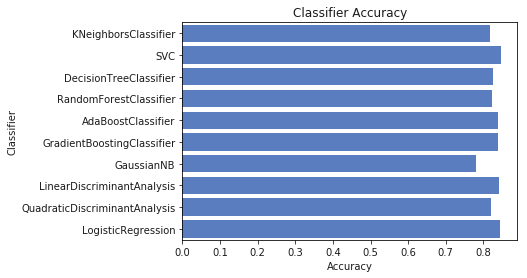

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train[0::, 1::]
y = train[0::, 0]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [46]:
acc_dict

{'AdaBoostClassifier': 0.8377777777777776,
 'DecisionTreeClassifier': 0.8255555555555555,
 'GaussianNB': 0.7799999999999999,
 'GradientBoostingClassifier': 0.8388888888888889,
 'KNeighborsClassifier': 0.8166666666666667,
 'LinearDiscriminantAnalysis': 0.8422222222222222,
 'LogisticRegression': 0.8444444444444444,
 'QuadraticDiscriminantAnalysis': 0.82,
 'RandomForestClassifier': 0.8233333333333333,
 'SVC': 0.8477777777777777}

----
----
----
----

# original

https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83/

# special

- cv 10
- less features
  - "Has_Cabin" feature does not help. 
  - "Deck" feature does not help. 
  - "Embarked" does not help
  - In my specific case turning Pclass into 3 features did not help, but as I learned it's a good idea to try both approaches and see what's better in your case.
  - Making Bins in Fare and Age helps a little bit.
- not using columns = [train_df, test_df]
  - data_df = train_df.append(test_df)
  - train_df['Age'] = data_df['Age'][:891]
- **make a Title feature for imputing ages**
  - titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
    - Replacing rare titles with more common ones
      - mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss','Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
- **Adding Family_Survival**
  - **this feature express that other member of passenger's family are survived or not.**
    - **this feature doesn't include my survival count.**
- Standard Scaler is our friend.
  - with KNN
  - There is not much sence in scaling features that are already 0 or 1 like Sex,
  - If you don't use bins (if you use Age or Fare "as is"), scaling may help to boost your score a bit, try it.




# score

- best score of 10 cv score: **0.879492358564**
- submit score: 0.83253

# columns

	Survived	Pclass	Sex	Family_Size	Family_Survival
    
# else



In [5]:
# NumPy
import numpy as np

# Dataframe operations
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Models
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.linear_model import Perceptron
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

In [11]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
data_df = train_df.append(test_df) # The entire data: train + test.

data_df['Title'] = data_df['Name']
# Cleaning name and extracting Title
for name_string in data_df['Name']:
    data_df['Title'] = data_df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# Replacing rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
data_df.replace({'Title': mapping}, inplace=True)
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in titles:
    age_to_impute = data_df.groupby('Title')['Age'].median()[titles.index(title)]
    data_df.loc[(data_df['Age'].isnull()) & (data_df['Title'] == title), 'Age'] = age_to_impute
    
# Substituting Age values in TRAIN_DF and TEST_DF:
train_df['Age'] = data_df['Age'][:891]
test_df['Age'] = data_df['Age'][891:]

# Dropping Title feature
data_df.drop('Title', axis = 1, inplace = True)


data_df['Family_Size'] = data_df['Parch'] + data_df['SibSp']

# Substituting Age values in TRAIN_DF and TEST_DF:
train_df['Family_Size'] = data_df['Family_Size'][:891]
test_df['Family_Size'] = data_df['Family_Size'][891:]



data_df['Last_Name'] = data_df['Name'].apply(lambda x: str.split(x, ",")[0])
data_df['Fare'].fillna(data_df['Fare'].mean(), inplace=True)

DEFAULT_SURVIVAL_VALUE = 0.5
data_df['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

# group of same family
for grp, grp_df in data_df[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            
            # If any family memebers survived, put this feature as 1
            # Otherwise if any family memebers perished, put this feature as 0
            if (smax == 1.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      data_df.loc[data_df['Family_Survival']!=0.5].shape[0])


# also, group of same friends. they have same Ticket feature.
for _, grp_df in data_df.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(data_df[data_df['Family_Survival']!=0.5].shape[0]))

# # Family_Survival in TRAIN_DF and TEST_DF:
train_df['Family_Survival'] = data_df['Family_Survival'][:891]
test_df['Family_Survival'] = data_df['Family_Survival'][891:]


data_df['Fare'].fillna(data_df['Fare'].median(), inplace = True)

# Making Bins
data_df['FareBin'] = pd.qcut(data_df['Fare'], 5)

label = LabelEncoder()
data_df['FareBin_Code'] = label.fit_transform(data_df['FareBin'])

train_df['FareBin_Code'] = data_df['FareBin_Code'][:891]
test_df['FareBin_Code'] = data_df['FareBin_Code'][891:]

train_df.drop(['Fare'], 1, inplace=True)
test_df.drop(['Fare'], 1, inplace=True)




data_df['AgeBin'] = pd.qcut(data_df['Age'], 4)

label = LabelEncoder()
data_df['AgeBin_Code'] = label.fit_transform(data_df['AgeBin'])

train_df['AgeBin_Code'] = data_df['AgeBin_Code'][:891]
test_df['AgeBin_Code'] = data_df['AgeBin_Code'][891:]

train_df.drop(['Age'], 1, inplace=True)
test_df.drop(['Age'], 1, inplace=True)



train_df['Sex'].replace(['male','female'],[0,1],inplace=True)
test_df['Sex'].replace(['male','female'],[0,1],inplace=True)

train_df.drop(['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
               'Embarked'], axis = 1, inplace = True)
test_df.drop(['Name','PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
              'Embarked'], axis = 1, inplace = True)


Number of passengers with family survival information: 420
Number of passenger with family/group survival information: 546


In [5]:
train_df.head(3)


,Survived,Pclass,Sex,Family_Size,Family_Survival,FareBin_Code,AgeBin_Code
0,0,3,0,1,0.5,0,0
1,1,1,1,1,0.5,4,3
2,1,3,1,0,0.5,1,1


In [7]:
X = train_df.drop('Survived', 1)
y = train_df['Survived']
X_test = test_df.copy()


std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)
X_test = std_scaler.transform(X_test)



n_neighbors = [6,7,8,9,10,11,12,14,16,18,20,22]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}
gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "roc_auc", n_jobs=3)
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

gd.best_estimator_.fit(X, y)
y_pred = gd.best_estimator_.predict(X_test)



Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=3)]: Done 766 tasks      | elapsed:    3.2s


0.879492358564122
KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=18, p=2,
           weights='uniform')


[Parallel(n_jobs=3)]: Done 2400 out of 2400 | elapsed:    7.6s finished


----
----
----
----



# original

https://www.kaggle.com/francksylla/titanic-machine-learning-from-disaster

0.82775

# points

- unique features
  - **'Ticket_perishing_women', 'Ticket_surviving_men', 'Surname_perishing_women', 'Surname_surviving_men'**

- features
  - **'female','male'**
    - one hot encoding
  - 'Age' 
  - **'male_adult','female_adult', 'child'**
    - age + sex feature in one feature
  - 'TitleCat', 'Pclass',
  - **'Ticket_Id'**
    - categorized same ticket member and add name for this group in Ticket_Id
  - **'Ticket_Members'**
    - num of same ticket member
  - 'NameLength',
  - **'CabinType'**
    - odd or even of cabin numer
  - 'CabinCat',  'SibSp', 'Parch', 'Fare','Embarked',
  - **'Surname_Members',**
    - same surname member num
  - 'FamilySize',
  - **'Ticket_perishing_women', 'Ticket_surviving_men', 'Surname_perishing_women', 'Surname_surviving_men'**
    - **first grouping by same Ticket or Surname**
    - **second, group by sex(female_adoult or male_adult)&Survived(or not)&Parch/SibSp**
      - same ticket & 
        - female_adult & not Survived & (Parch >0 or SibSp >0)
        - or
        - male_adult & Survived & (Parch >0 or SibSp >0)
      - same surname &
        - female_adult & not Survived & (Parch >0 or SibSp >0)
        - or
        - male_adult & Survived & (Parch >0 or SibSp >0)
- making ExtraTreesRegressor for filling missing Age feature



In [36]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor
from sklearn import cross_validation
import re
import operator
from sklearn.feature_selection import SelectKBest, f_classif

#Print you can execute arbitrary python code
train = pd.read_csv("../input/train.csv", dtype={"Age": np.float64}, )
test = pd.read_csv("../input/test.csv", dtype={"Age": np.float64}, )

target = train["Survived"].values
full = pd.concat([train, test])
#print(full.head())
#print(full.describe())
#print(full.info())

full['surname'] = full["Name"].apply(lambda x: x.split(',')[0].lower())

full["Title"] = full["Name"].apply(lambda x: re.search(' ([A-Za-z]+)\.',x).group(1))
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 2, "Mme": 3,"Don": 9,"Dona": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
full["TitleCat"] = full.loc[:,'Title'].map(title_mapping)

full["FamilySize"] = full["SibSp"] + full["Parch"] + 1
full["FamilySize"] = pd.cut(full["FamilySize"], bins=[0,1,4,20], labels=[0,1,2])

full["NameLength"] = full["Name"].apply(lambda x: len(x))

full["Embarked"] = pd.Categorical.from_array(full.Embarked).codes

full["Fare"] = full["Fare"].fillna(8.05)

full = pd.concat([full,pd.get_dummies(full['Sex'])],axis=1)

full['CabinCat'] = pd.Categorical.from_array(full.Cabin.fillna('0').apply(lambda x: x[0])).codes

# function to get oven/odd/null from cabine 
def get_type_cabine(cabine):
    # Use a regular expression to search for a title. 
    cabine_search = re.search('\d+', cabine)
    # If the title exists, extract and return it.
    if cabine_search:
        num = cabine_search.group(0)
        if np.float64(num) % 2 == 0:
            return '2'
        else:
            return '1'
    return '0'
full["Cabin"] = full["Cabin"].fillna(" ")

full["CabinType"] = full["Cabin"].apply(get_type_cabine)
#print(pd.value_counts(full["CabinType"]))



#### CHILD/FEMALE ADULT/MALE ADULT------------------------------------------------------------
child_age = 18
def get_person(passenger):
    age, sex = passenger
    if (age < child_age):
        return 'child'
    elif (sex == 'female'):
        return 'female_adult'
    else:
        return 'male_adult'
full = pd.concat([full, pd.DataFrame(full[['Age', 'Sex']].apply(get_person, axis=1), columns=['person'])],axis=1)
full = pd.concat([full,pd.get_dummies(full['person'])],axis=1)

### FEATURES BASED ON TICKET   --------------------------------------------------------
table_ticket = pd.DataFrame(full["Ticket"].value_counts())
table_ticket.rename(columns={'Ticket':'Ticket_Members'}, inplace=True)

table_ticket['Ticket_perishing_women'] = full.Ticket[(full.female_adult == 1.0) 
                                    & (full.Survived == 0.0) 
                                    & ((full.Parch > 0) | (full.SibSp > 0))].value_counts()
table_ticket['Ticket_perishing_women'] = table_ticket['Ticket_perishing_women'].fillna(0)
table_ticket['Ticket_perishing_women'][table_ticket['Ticket_perishing_women'] > 0] = 1.0 

table_ticket['Ticket_surviving_men'] = full.Ticket[(full.male_adult == 1.0) 
                                    & (full.Survived == 1.0) 
                                    & ((full.Parch > 0) | (full.SibSp > 0))].value_counts()
table_ticket['Ticket_surviving_men'] = table_ticket['Ticket_surviving_men'].fillna(0)
table_ticket['Ticket_surviving_men'][table_ticket['Ticket_surviving_men'] > 0] = 1.0 

table_ticket["Ticket_Id"]= pd.Categorical.from_array(table_ticket.index).codes
# compress under 3 members into one code.
table_ticket["Ticket_Id"][table_ticket["Ticket_Members"] < 3 ] = -1
table_ticket["Ticket_Members"] = pd.cut(table_ticket["Ticket_Members"], bins=[0,1,4,20], labels=[0,1,2])

full = pd.merge(full, table_ticket, left_on="Ticket",right_index=True,how='left', sort=False)

### FEATURES BASED ON SURNAME    --------------------------------------------------------
table_surname = pd.DataFrame(full["surname"].value_counts())
table_surname.rename(columns={'surname':'Surname_Members'}, inplace=True)

table_surname['Surname_perishing_women'] = full.surname[(full.female_adult == 1.0) 
                                    & (full.Survived == 0.0) 
                                    & ((full.Parch > 0) | (full.SibSp > 0))].value_counts()
table_surname['Surname_perishing_women'] = table_surname['Surname_perishing_women'].fillna(0)
table_surname['Surname_perishing_women'][table_surname['Surname_perishing_women'] > 0] = 1.0 

table_surname['Surname_surviving_men'] = full.surname[(full.male_adult == 1.0) 
                                    & (full.Survived == 1.0) 
                                    & ((full.Parch > 0) | (full.SibSp > 0))].value_counts()
table_surname['Surname_surviving_men'] = table_surname['Surname_surviving_men'].fillna(0)
table_surname['Surname_surviving_men'][table_surname['Surname_surviving_men'] > 0] = 1.0 

table_surname["Surname_Id"]= pd.Categorical.from_array(table_surname.index).codes
# compress under 3 members into one code.
table_surname["Surname_Id"][table_surname["Surname_Members"] < 3 ] = -1

table_surname["Surname_Members"] = pd.cut(table_surname["Surname_Members"], bins=[0,1,4,20], labels=[0,1,2])

full = pd.merge(full, table_surname, left_on="surname",right_index=True,how='left', sort=False)

### AGE PROCESSING --------------------------------------------------------------------------
classers = ['Fare','Parch','Pclass','SibSp','TitleCat', 
'CabinCat','female','male', 'Embarked', 'FamilySize', 'NameLength','Ticket_Members','Ticket_Id']
etr = ExtraTreesRegressor(n_estimators=200)
X_train = full[classers][full['Age'].notnull()]
Y_train = full['Age'][full['Age'].notnull()]
X_test = full[classers][full['Age'].isnull()]
etr.fit(X_train,np.ravel(Y_train))
age_preds = etr.predict(X_test)
full['Age'][full['Age'].isnull()] = age_preds

# FEATURES -----------------------------------------------------------------------------------
features = ['female','male','Age','male_adult','female_adult', 'child','TitleCat', 'Pclass',
'Pclass','Ticket_Id','NameLength','CabinType','CabinCat', 'SibSp', 'Parch',
'Fare','Embarked','Surname_Members','Ticket_Members','FamilySize',
'Ticket_perishing_women','Ticket_surviving_men',
'Surname_perishing_women','Surname_surviving_men']

train = full[0:891].copy()
test = full[891:].copy()

selector = SelectKBest(f_classif, k=len(features))
selector.fit(train[features], target)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]
print("Features importance :")
for f in range(len(scores)):
    print("%0.2f %s" % (scores[indices[f]],features[indices[f]]))

# BEST CLASSIFIER METHOD ==> RANDOM FOREST -----------------------------------------------------
rfc = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745,1:0.255})


# CROSS VALIDATION WITH RANDOM FOREST CLASSIFIER METHOD-----------------------------------------
kf = cross_validation.KFold(train.shape[0], n_folds=3, random_state=1)

scores = cross_validation.cross_val_score(rfc, train[features], target, cv=kf)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean()*100, scores.std()*100, 'RFC Cross Validation'))
rfc.fit(train[features], target)
score = rfc.score(train[features], target)
print("Accuracy: %0.3f            [%s]" % (score*100, 'RFC full test'))
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(features)):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f]+1, importances[indices[f]]*100, features[indices[f]]))


# PREDICTION  -----------------------------------------------------------------------------------
rfc.fit(train[features], target)
predictions = rfc.predict(test[features])

# OUTPUT FILE -----------------------------------------------------------------------------------
PassengerId =np.array(test["PassengerId"]).astype(int)
my_prediction = pd.DataFrame(predictions, PassengerId, columns = ["Survived"])

#my_prediction.to_csv("my_prediction.csv", index_label = ["PassengerId"])

print("The end ...")

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


Features importance :
68.85 female
68.85 male
64.90 male_adult
53.23 female_adult
26.22 TitleCat
24.60 Pclass
24.60 Pclass
23.69 NameLength
17.75 CabinCat
17.00 Ticket_surviving_men
16.28 CabinType
14.21 Fare
13.54 Ticket_perishing_women
13.04 Surname_surviving_men
10.36 Surname_perishing_women
6.94 Embarked
5.27 Ticket_Members
3.59 child
2.93 FamilySize
1.83 Parch
1.75 Age
1.07 Ticket_Id
0.73 Surname_Members
0.53 SibSp
Accuracy: 89.338 (+/- 0.97) [RFC Cross Validation]
Accuracy: 96.409            [RFC full test]
1. feature 3 (9.099659) Age
2. feature 16 (8.940850) Fare
3. feature 11 (8.424021) NameLength
4. feature 21 (7.014200) Ticket_perishing_women
5. feature 7 (7.005833) TitleCat
6. feature 2 (6.897956) male
7. feature 23 (6.765696) Surname_perishing_women
8. feature 1 (5.766599) female
9. feature 4 (5.023490) male_adult
10. feature 22 (4.452971) Ticket_surviving_men
11. feature 8 (3.868393) Pclass
12. feature 9 (3.857094) Pclass
13. feature 5 (3.669267) female_adult
14. feature 1

In [37]:
train.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,female_adult,male_adult,Ticket_Members,Ticket_perishing_women,Ticket_surviving_men,Ticket_Id,Surname_Members,Surname_perishing_women,Surname_surviving_men,Surname_Id
0,22.0,,2,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,...,0,1,0,0.0,0.0,-1,1,0.0,0.0,-1
1,38.0,C85,0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,1,0,1,0.0,0.0,-1,1,0.0,0.0,-1
2,26.0,,2,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,...,1,0,0,0.0,0.0,-1,0,0.0,0.0,-1
3,35.0,C123,2,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,1,0,1,0.0,0.0,-1,1,0.0,0.0,-1
4,35.0,,2,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,...,0,1,0,0.0,0.0,-1,1,0.0,0.0,-1


In [89]:
test[['Ticket_perishing_women', 'Ticket_surviving_men', 'Surname_perishing_women', 'Surname_surviving_men']]

,Ticket_perishing_women,Ticket_surviving_men,Surname_perishing_women,Surname_surviving_men
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0


In [93]:
test["Ticket_perishing_women"].value_counts()

0.0    396
1.0     22
Name: Ticket_perishing_women, dtype: int64

In [97]:
test["Ticket_surviving_men"].value_counts()

0.0    410
1.0      8
Name: Ticket_surviving_men, dtype: int64

In [98]:
test["Surname_perishing_women"].value_counts()

0.0    394
1.0     24
Name: Surname_perishing_women, dtype: int64

In [99]:
test["Surname_surviving_men"].value_counts()

0.0    409
1.0      9
Name: Surname_surviving_men, dtype: int64

In [100]:
train["Surname_surviving_men"].value_counts()

0.0    847
1.0     44
Name: Surname_surviving_men, dtype: int64

In [85]:
full.surname[(full.female_adult == 1.0) 
                                    & (full.Survived == 0.0) 
                                    & ((full.Parch > 0) | (full.SibSp > 0))]

18      vander planke
38      vander planke
40              ahlin
41             turpin
49     arnold-franchi
113           jussila
132            robins
140            boulos
167             skoog
180              sage
229           lefebre
240            zabour
251             strom
254           rosblom
312          lahtinen
362           barbara
402           jussila
409           lefebre
423            danbom
436              ford
485           lefebre
498           allison
567           palsson
578             caram
593            bourke
610         andersson
617              lobb
638            panula
657            bourke
678           goodwin
702           barbara
729        ilmakangas
736              ford
792              sage
799          van impe
854            carter
863              sage
885              rice
888          johnston
Name: surname, dtype: object

In [53]:
train[["Ticket_Members", "Ticket", "Ticket_Id"]]

,Ticket_Members,Ticket,Ticket_Id
0,0,A/5 21171,-1
1,1,PC 17599,-1
2,0,STON/O2. 3101282,-1
3,1,113803,-1
4,0,373450,-1
5,0,330877,-1
6,1,17463,-1
7,2,349909,541
8,1,347742,477
9,1,237736,-1


----
----
----
----

# original

https://www.kaggle.com/scirpus/genetic-programming-lb-0-88

# points

- maybe it is result of GP
  - not written by hand
- still searching the GP program on
  - https://www.kaggle.com/scirpus/genetic-programming-lb-0-88/comments
  - **todo**
 

In [ ]:
import numpy as np
import pandas as pd


def Outputs(data):
    return np.round(1.-(1./(1.+np.exp(-data))))


def GeneticFunction(data):
    return ((np.minimum( ((((0.058823499828577 + data["Sex"]) - np.cos((data["Pclass"] / 2.0))) * 2.0)),  ((0.885868))) * 2.0) +
            np.maximum( ((data["SibSp"] - 2.409090042114258)),  ( -(np.minimum( (data["Sex"]),  (np.sin(data["Parch"]))) * data["Pclass"]))) +
            (0.138462007045746 * ((np.minimum( (data["Sex"]),  (((data["Parch"] / 2.0) / 2.0))) * data["Age"]) - data["Cabin"])) +
            np.minimum( ((np.sin((data["Parch"] * ((data["Fare"] - 0.720430016517639) * 2.0))) * 2.0)),  ((data["SibSp"] / 2.0))) +
            np.maximum( (np.minimum( ( -np.cos(data["Embarked"])),  (0.138462007045746))),  (np.sin(((data["Cabin"] - data["Fare"]) * 2.0)))) +
            -np.minimum( ((((data["Age"] * data["Parch"]) * data["Embarked"]) + data["Parch"])),  (np.sin(data["Pclass"]))) +
            np.minimum( (data["Sex"]),  ((np.sin( -(data["Fare"] * np.cos((data["Fare"] * 1.630429983139038)))) / 2.0))) +
            np.minimum( ((0.230145)),  (np.sin(np.minimum( (((67.0 / 2.0) * np.sin(data["Fare"]))),  (0.31830988618379069))))) +
            np.sin((np.sin(data["Cabin"]) * (np.sin((12.6275)) * np.maximum( (data["Age"]),  (data["Fare"]))))) +
            np.sin(((np.minimum( (data["Fare"]),  ((data["Cabin"] * data["Embarked"]))) / 2.0) *  -data["Fare"])) +
            np.minimum( (((2.675679922103882 * data["SibSp"]) * np.sin(((96) * np.sin(data["Cabin"]))))),  (data["Parch"])) +
            np.sin(np.sin((np.maximum( (np.minimum( (data["Age"]),  (data["Cabin"]))),  ((data["Fare"] * 0.31830988618379069))) * data["Cabin"]))) +
            np.maximum( (np.sin(((12.4148) * (data["Age"] / 2.0)))),  (np.sin((-3.0 * data["Cabin"])))) +
            (np.minimum( (np.sin((((np.sin(((data["Fare"] * 2.0) * 2.0)) * 2.0) * 2.0) * 2.0))),  (data["SibSp"])) / 2.0) +
            ((data["Sex"] - data["SibSp"]) * (np.cos(((data["Embarked"] - 0.730768978595734) + data["Age"])) / 2.0)) +
            ((np.sin(data["Cabin"]) / 2.0) - (np.cos(np.minimum( (data["Age"]),  (data["Embarked"]))) * np.sin(data["Embarked"]))) +
            np.minimum( (0.31830988618379069),  ((data["Sex"] * (2.212120056152344 * (0.720430016517639 - np.sin((data["Age"] * 2.0))))))) +
            (np.minimum( (np.cos(data["Fare"])),  (np.maximum( (np.sin(data["Age"])),  (data["Parch"])))) * np.cos((data["Fare"] / 2.0))) +
            np.sin((data["Parch"] * np.minimum( ((data["Age"] - 1.5707963267948966)),  ((np.cos((data["Pclass"] * 2.0)) / 2.0))))) +
            (data["Parch"] * (np.sin(((data["Fare"] * (0.623655974864960 * data["Age"])) * 2.0)) / 2.0)) +
            (0.31830988618379069 * np.cos(np.maximum( ((0.602940976619720 * data["Fare"])),  ((np.sin(0.720430016517639) * data["Age"]))))) +
            (np.minimum( ((data["SibSp"] / 2.0)),  (np.sin(((data["Pclass"] - data["Fare"]) * data["SibSp"])))) * data["SibSp"]) +
            np.tanh((data["Sex"] * np.sin((5.199999809265137 * np.sin((data["Cabin"] * np.cos(data["Fare"]))))))) +
            (np.minimum( (data["Parch"]),  (data["Sex"])) * np.cos(np.maximum( ((np.cos(data["Parch"]) + data["Age"])),  (3.1415926535897931)))) +
            (np.minimum( (np.tanh(((data["Cabin"] / 2.0) + data["Parch"]))),  ((data["Sex"] + np.cos(data["Age"])))) / 2.0) +
            (np.sin((np.sin(data["Sex"]) * (np.sin((data["Age"] * data["Pclass"])) * data["Pclass"]))) / 2.0) +
            (data["Sex"] * (np.cos(((data["Sex"] + data["Fare"]) * ((8.48635) * (63)))) / 2.0)) +
            np.minimum( (data["Sex"]),  ((np.cos((data["Age"] * np.tanh(np.sin(np.cos(data["Fare"]))))) / 2.0))) +
            (np.tanh(np.tanh( -np.cos((np.maximum( (np.cos(data["Fare"])),  (0.094339601695538)) * data["Age"])))) / 2.0) +
            (np.tanh(np.cos((np.cos(data["Age"]) + (data["Age"] + np.minimum( (data["Fare"]),  (data["Age"])))))) / 2.0) +
            (np.tanh(np.cos((data["Age"] * ((-2.0 + np.sin(data["SibSp"])) + data["Fare"])))) / 2.0) +
            (np.minimum( (((281) - data["Fare"])),  (np.sin((np.maximum( ((176)),  (data["Fare"])) * data["SibSp"])))) * 2.0) +
            np.sin(((np.maximum( (data["Embarked"]),  (data["Age"])) * 2.0) * (((785) * 3.1415926535897931) * data["Age"]))) +
            np.minimum( (data["Sex"]),  (np.sin( -(np.minimum( ((data["Cabin"] / 2.0)),  (data["SibSp"])) * (data["Fare"] / 2.0))))) +
            np.sin(np.sin((data["Cabin"] * (data["Embarked"] + (np.tanh( -data["Age"]) + data["Fare"]))))) +
            (np.cos(np.cos(data["Fare"])) * (np.sin((data["Embarked"] - ((734) * data["Fare"]))) / 2.0)) +
            ((np.minimum( (data["SibSp"]),  (np.cos(data["Fare"]))) * np.cos(data["SibSp"])) * np.sin((data["Age"] / 2.0))) +
            (np.sin((np.sin((data["SibSp"] * np.cos((data["Fare"] * 2.0)))) + (data["Cabin"] * 2.0))) / 2.0) +
            (((data["Sex"] * data["SibSp"]) * np.sin(np.sin( -(data["Fare"] * data["Cabin"])))) * 2.0) +
            (np.sin((data["SibSp"] * ((((5.428569793701172 + 67.0) * 2.0) / 2.0) * data["Age"]))) / 2.0) +
            (data["Pclass"] * (np.sin(((data["Embarked"] * data["Cabin"]) * (data["Age"] - (1.07241)))) / 2.0)) +
            (np.cos((((( -data["SibSp"] + data["Age"]) + data["Parch"]) * data["Embarked"]) / 2.0)) / 2.0) +
            (0.31830988618379069 * np.sin(((data["Age"] * ((data["Embarked"] * np.sin(data["Fare"])) * 2.0)) * 2.0))) +
            ((np.minimum( ((data["Age"] * 0.058823499828577)),  (data["Sex"])) - 0.63661977236758138) * np.tanh(np.sin(data["Pclass"]))) +
            -np.minimum( ((np.cos(((727) * ((data["Fare"] + data["Parch"]) * 2.0))) / 2.0)),  (data["Fare"])) +
            (np.minimum( (np.cos(data["Fare"])),  (data["SibSp"])) * np.minimum( (np.sin(data["Parch"])),  (np.cos((data["Embarked"] * 2.0))))) +
            (np.minimum( (((data["Fare"] / 2.0) - 2.675679922103882)),  (0.138462007045746)) * np.sin((1.5707963267948966 * data["Age"]))) +
            np.minimum( ((0.0821533)),  (((np.sin(data["Fare"]) + data["Embarked"]) - np.cos((data["Age"] * (9.89287)))))))


def MungeData(data):
    # Sex
    data.drop(['Ticket', 'Name'], inplace=True, axis=1)
    data.Sex.fillna('0', inplace=True)
    data.loc[data.Sex != 'male', 'Sex'] = 0
    data.loc[data.Sex == 'male', 'Sex'] = 1
    # Cabin
    data.Cabin.fillna('0', inplace=True)
    data.loc[data.Cabin.str[0] == 'A', 'Cabin'] = 1
    data.loc[data.Cabin.str[0] == 'B', 'Cabin'] = 2
    data.loc[data.Cabin.str[0] == 'C', 'Cabin'] = 3
    data.loc[data.Cabin.str[0] == 'D', 'Cabin'] = 4
    data.loc[data.Cabin.str[0] == 'E', 'Cabin'] = 5
    data.loc[data.Cabin.str[0] == 'F', 'Cabin'] = 6
    data.loc[data.Cabin.str[0] == 'G', 'Cabin'] = 7
    data.loc[data.Cabin.str[0] == 'T', 'Cabin'] = 8
    # Embarked
    data.loc[data.Embarked == 'C', 'Embarked'] = 1
    data.loc[data.Embarked == 'Q', 'Embarked'] = 2
    data.loc[data.Embarked == 'S', 'Embarked'] = 3
    data.Embarked.fillna(0, inplace=True)
    data.fillna(-1, inplace=True)
    return data.astype(float)


if __name__ == "__main__":
    train = pd.read_csv('../input/train.csv')
    test = pd.read_csv('../input/test.csv')
    mungedtrain = MungeData(train)
    trainPredictions = Outputs(GeneticFunction(mungedtrain))

    pdtrain = pd.DataFrame({'PassengerId': mungedtrain.PassengerId.astype(int),
                            'Predicted': trainPredictions.astype(int),
                            'Survived': mungedtrain.Survived.astype(int)})
    pdtrain.to_csv('gptrain.csv', index=False)
    mungedtest = MungeData(test)
    testPredictions = Outputs(GeneticFunction(mungedtest))

    pdtest = pd.DataFrame({'PassengerId': mungedtest.PassengerId.astype(int),
                            'Survived': testPredictions.astype(int)})
    pdtest.to_csv('gptest.csv', index=False)

----
----
----
----


**this is just tutorial of data science. I can skip it**

# original

https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy


# points


 

----
----
----
----

# original

https://www.kaggle.com/gaohong/roy-s-titanic-notebook

# points

- survival features with friends and family
  - simimalr to Family_Survival feature
  - columns = ['Pclass', 'SexInt', 'EmbarkedInt', 'Age', 'TitleInt','Fare', 
        'Friends', 'Male_Friends_Survived', 'Male_Friends_NotSurvived', 'Female_Friends_Survived', 'Female_Friends_NotSurvived',
        'MotherOnBoard', 'MotherSurvived', 'ChildOnBoard', 'ChildSurvived', 'ChildNotSurvived']
- using several models and conbine the result
  - more thant 2 models estimate as 1, the conbined model estimate 1. the others is 0.
  - conbined models
    - random forest
    - nn by keras
    - gp by deap(only result of deap was used)
- using xgboosting for trial
- 0.8134
    

In [2]:
import pandas as pd
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null 

In [3]:
#Use the Regular Expression to get the title from the name field.
import re
pattern = re.compile(r'.*?,(.*?)\.')
def getTitle(x):
    result = pattern.search(x)
    if result:
        return result.group(1).strip()
    else:
        return ''

train['Title'] = train['Name'].map(getTitle)
test['Title'] = test['Name'].map(getTitle)

#Check how many rows missing the Age by Title
print(train['Title'][train['Age'].isnull()].value_counts())
print(test['Title'][test['Age'].isnull()].value_counts())

#Set the missing Age of Title 'Master' 
master_age_mean = train['Age'][(train['Title']=='Master')&(train['Age']>0)].mean()
train.loc[train[(train['Title']=='Master')&(train['Age'].isnull())].index, 'Age'] = master_age_mean
test.loc[test[(test['Title']=='Master')&(test['Age'].isnull())].index, 'Age'] = master_age_mean

#Set the missing Age of Title 'Mr' 
mr_age_mean = train['Age'][(train['Title']=='Mr')&(train['Age']>0)].mean()
train.loc[train[(train['Title']=='Mr')&(train['Age'].isnull())].index, 'Age'] = mr_age_mean
test.loc[test[(test['Title']=='Mr')&(test['Age'].isnull())].index, 'Age'] = mr_age_mean

#Set the missing Age of Title 'Miss' or 'Ms'
miss_age_mean = train['Age'][(train['Title']=='Miss')&(train['Age']>0)].mean()
train.loc[train[(train['Title']=='Miss')&(train['Age'].isnull())].index, 'Age'] = miss_age_mean
test.loc[test[((test['Title']=='Miss')|(test['Title']=='Ms'))&(test['Age'].isnull())].index, 'Age'] = miss_age_mean

#Set the missing Age of Title 'Mrs' 
mrs_age_mean = train['Age'][(train['Title']=='Mrs')&(train['Age']>0)].mean()
train.loc[train[(train['Title']=='Mrs')&(train['Age'].isnull())].index, 'Age'] = mrs_age_mean
test.loc[test[(test['Title']=='Mrs')&(test['Age'].isnull())].index, 'Age'] = mrs_age_mean

#Set the missing Age of Title 'Dr' 
dr_age_mean = train['Age'][(train['Title']=='Dr')&(train['Age']>0)].mean()
train.loc[train[(train['Title']=='Dr')&(train['Age'].isnull())].index, 'Age'] = dr_age_mean
test.loc[test[(test['Title']=='Mrs')&(test['Age'].isnull())].index, 'Age'] = dr_age_mean

print(train['Age'].describe())
print(test['Age'].describe())

Mr        119
Miss       36
Mrs        17
Master      4
Dr          1
Name: Title, dtype: int64
Mr        57
Miss      14
Mrs       10
Master     4
Ms         1
Name: Title, dtype: int64
count    891.000000
mean      29.754659
std       13.277179
min        0.420000
25%       21.773973
50%       30.000000
75%       35.898148
max       80.000000
Name: Age, dtype: float64
count    418.000000
mean      30.142031
std       13.034817
min        0.170000
25%       21.830479
50%       30.000000
75%       35.974537
max       76.000000
Name: Age, dtype: float64


/home/yuki/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


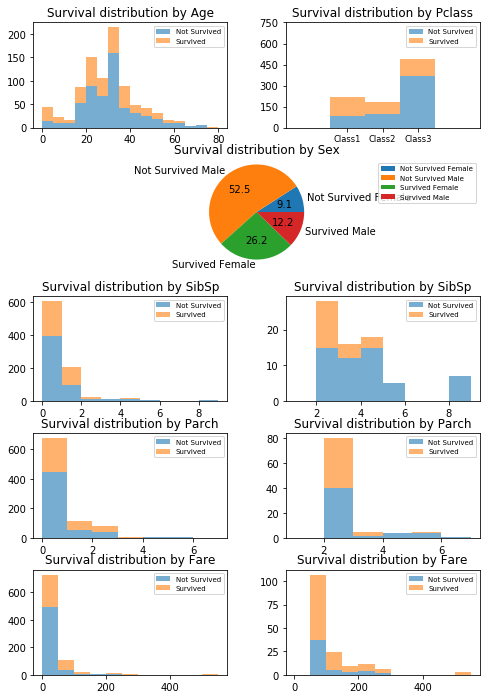

In [5]:
import matplotlib.pyplot as plt
alpha = 0.6
fig = plt.figure(figsize=(8, 12))
grouped = train.groupby(['Survived'])
group0 = grouped.get_group(0)
group1 = grouped.get_group(1)

plot_rows = 5
plot_cols = 2
ax1 = plt.subplot2grid((plot_rows,plot_cols), (0,0), rowspan=1, colspan=1)
plt.hist([group0.Age, group1.Age], bins=16, range=(0,80), stacked=True, 
        label=['Not Survived', 'Survived'], alpha=alpha)
plt.legend(loc='best', fontsize='x-small')
ax1.set_title('Survival distribution by Age')

ax2 = plt.subplot2grid((plot_rows,plot_cols), (0,1), rowspan=1, colspan=1)
n, bins, patches = plt.hist([group0.Pclass, group1.Pclass], bins=5, range=(0,5), 
        stacked=True, label=['Not Survived', 'Survived'], alpha=alpha)
plt.legend(loc='best', fontsize='x-small')
ax2.set_xticks([1.5, 2.5, 3.5])
ax2.set_xticklabels(['Class1', 'Class2', 'Class3'], fontsize='small')
ax2.set_yticks([0, 150, 300, 450, 600, 750])
ax2.set_title('Survival distribution by Pclass')

ax3 = plt.subplot2grid((plot_rows,plot_cols), (1,0), rowspan=1, colspan=2)
ax3.set_title('Survival distribution by Sex')
patches, l_texts, p_texts = plt.pie(train.groupby(['Survived', 'Sex']).size(), 
        labels=['Not Survived Female', 'Not Survived Male', 'Survived Female', 'Survived Male'],
        autopct='%3.1f', labeldistance = 1.1, pctdistance = 0.6)
plt.legend(loc='upper right', fontsize='x-small')
for t in l_texts:
    t.set_size(10)
for p in p_texts:
    p.set_size(10)
#plt.legend(loc='best', fontsize='x-small')
plt.axis('equal')

ax4 = plt.subplot2grid((plot_rows,plot_cols), (2,0), rowspan=1, colspan=1)
ax4.set_title('Survival distribution by SibSp')
plt.hist([group0.SibSp, group1.SibSp], bins=9, range=(0,9), stacked=True, 
        label=['Not Survived', 'Survived'], log=False, alpha=alpha)
plt.legend(loc='best', fontsize='x-small')

ax5 = plt.subplot2grid((plot_rows,plot_cols), (2,1), rowspan=1, colspan=1)
ax5.set_title('Survival distribution by SibSp')
plt.hist([group0[group0.SibSp>1].SibSp, group1[group1.SibSp>1].SibSp], bins=8, range=(1, 9), stacked=True, 
        label=['Not Survived', 'Survived'], log=False, alpha=alpha)
plt.legend(loc='best', fontsize='x-small')

ax6 = plt.subplot2grid((plot_rows,plot_cols), (3,0), rowspan=1, colspan=1)
ax6.set_title('Survival distribution by Parch')
plt.hist([group0.Parch, group1.Parch], bins=7, range=(0,7), stacked=True, 
        label=['Not Survived', 'Survived'], log=False, alpha=alpha)
plt.legend(loc='best', fontsize='x-small')

ax7 = plt.subplot2grid((plot_rows,plot_cols), (3,1), rowspan=1, colspan=1)
ax7.set_title('Survival distribution by Parch')
plt.hist([group0[group0.Parch>1].Parch, group1[group1.Parch>1].Parch], bins=6, range=(1, 7), stacked=True, 
        label=['Not Survived', 'Survived'], log=False, alpha=alpha)
plt.legend(loc='best', fontsize='x-small')

ax8 = plt.subplot2grid((plot_rows,plot_cols), (4,0), rowspan=1, colspan=1)
ax8.set_title('Survival distribution by Fare')
plt.hist([group0.Fare, group1.Fare], bins=11, range=(0, 550), stacked=True, 
        label=['Not Survived', 'Survived'], log=False, alpha=alpha)
plt.legend(loc='best', fontsize='x-small')

ax9 = plt.subplot2grid((plot_rows,plot_cols), (4,1), rowspan=1, colspan=1)
ax9.set_title('Survival distribution by Fare')
plt.hist([group0[group0.Fare>50].Fare, group1[group1.Fare>50].Fare], bins=11, range=(0, 550), stacked=True, 
        label=['Not Survived', 'Survived'], log=False, alpha=alpha)
plt.legend(loc='best', fontsize='x-small')
plt.subplots_adjust(wspace=0.3, hspace=0.3)

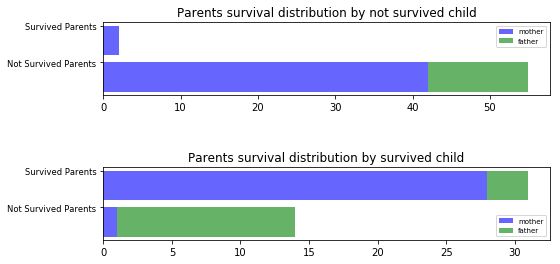

In [6]:
childgrouped = train[train['Age']<19].groupby(['Survived'])
childgroup0 = childgrouped.get_group(0)
childgroup1 = childgrouped.get_group(1)
parent = train[(train['Age']>18)&(train['Parch']>0)]

merged0 = pd.merge(childgroup0, parent, how='left', on='Ticket')
merged0 = merged0[['Survived_x', 'Sex_x', 'Age_x', 'Survived_y', 'Sex_y', 'Age_y', 'Ticket']]
merged0 = merged0[merged0.Survived_y>=0]
fig = plt.figure(figsize=(8, 4))
plot_rows = 2
plot_cols = 1
ax1 = plt.subplot2grid((plot_rows,plot_cols), (0,0), rowspan=1, colspan=1)
bottom = merged0.Survived_y.value_counts().index
width1 = merged0[merged0['Sex_y']=='female'].Survived_y.value_counts()
plt.barh(bottom, width1, 0.8, 0.0, color='blue', label='mother', alpha=0.6)
width2 = merged0[merged0['Sex_y']=='male'].Survived_y.value_counts()
plt.barh(width2.index, width2, 0.8, width1[width2.index], color='green', label='father', alpha=0.6)
plt.legend(loc='best', fontsize='x-small')
ax1.set_yticks([0.4, 1.4])
ax1.set_yticklabels(['Not Survived Parents', 'Survived Parents'], fontsize='small')
ax1.set_title('Parents survival distribution by not survived child')

merged1 = pd.merge(childgroup1, parent, how='left', on='Ticket')
merged1 = merged1[['Survived_x', 'Sex_x', 'Age_x', 'Survived_y', 'Sex_y', 'Age_y', 'Ticket']]
merged1 = merged1[merged1.Survived_y>=0]
ax2 = plt.subplot2grid((plot_rows,plot_cols), (1,0), rowspan=1, colspan=1)
bottom = merged1.Survived_y.value_counts().index
width1 = merged1[merged1['Sex_y']=='female'].Survived_y.value_counts()
plt.barh(bottom, width1, 0.8, 0.0, color='blue', label='mother', alpha=0.6)
width2 = merged1[merged1['Sex_y']=='male'].Survived_y.value_counts()
plt.barh(width2.index, width2, 0.8, width1[width2.index], color='green', label='father', alpha=0.6)
plt.legend(loc='best', fontsize='x-small')
ax2.set_yticks([0.4, 1.4])
ax2.set_yticklabels(['Not Survived Parents', 'Survived Parents'], fontsize='small')
ax2.set_title('Parents survival distribution by survived child')

plt.subplots_adjust(hspace=1.0)

In [7]:
ticket = train['Ticket'][train['Parch']==0]
ticket_dup = ticket.duplicated(False)
index = ticket_dup[ticket_dup==True].index
new_train = train.loc[index]
new_train['FriendsSurvived'] = -1
for i in range(0, len(index)):
    ticketID = new_train.loc[index[i]]['Ticket']
    passengerID = new_train.loc[index[i]]['PassengerId']
    survived = new_train['Survived'][(new_train['Ticket']==ticketID)&(new_train['PassengerId']!=passengerID)]
    new_train.loc[index[i], 'FriendsSurvived'] = round(float(survived.sum())/len(survived))
print(new_train[(new_train['Sex']=='female')&(new_train['Survived']==0)].FriendsSurvived.value_counts())
print(new_train[(new_train['Sex']=='male')&(new_train['Survived']==0)].FriendsSurvived.value_counts())
print(new_train[(new_train['Sex']=='female')&(new_train['Survived']==1)].FriendsSurvived.value_counts())
print(new_train[(new_train['Sex']=='male')&(new_train['Survived']==1)].FriendsSurvived.value_counts())

0    9
Name: FriendsSurvived, dtype: int64
0    38
1    26
Name: FriendsSurvived, dtype: int64
1    36
0    24
Name: FriendsSurvived, dtype: int64
1    19
0     2
Name: FriendsSurvived, dtype: int64


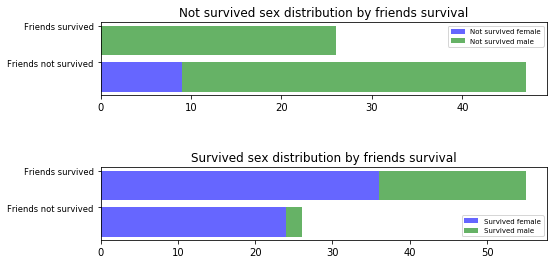

In [8]:
fig = plt.figure(figsize=(8, 4))
plot_rows = 2
plot_cols = 1
ax1 = plt.subplot2grid((plot_rows,plot_cols), (0,0), rowspan=1, colspan=1)
width1 = new_train[(new_train['Sex']=='female')&(new_train['Survived']==0)].FriendsSurvived.value_counts()
plt.barh(width1.index, width1, 0.8, 0.0, color='blue', label='Not survived female', alpha=0.6)
width2 = new_train[(new_train['Sex']=='male')&(new_train['Survived']==0)].FriendsSurvived.value_counts()
plt.barh(width2.index, width2, 0.8, [width1, 0.0], color='green', label='Not survived male', alpha=0.6)
plt.legend(loc='best', fontsize='x-small')
ax1.set_yticks([0.4, 1.4])
ax1.set_yticklabels(['Friends not survived', 'Friends survived'], fontsize='small')
ax1.set_title('Not survived sex distribution by friends survival')

ax2 = plt.subplot2grid((plot_rows,plot_cols), (1,0), rowspan=1, colspan=1)
width1 = new_train[(new_train['Sex']=='female')&(new_train['Survived']==1)].FriendsSurvived.value_counts()
plt.barh(width1.index, width1, 0.8, 0.0, color='blue', label='Survived female', alpha=0.6)
width2 = new_train[(new_train['Sex']=='male')&(new_train['Survived']==1)].FriendsSurvived.value_counts()
plt.barh(width2.index, width2, 0.8, width1[width2.index], color='green', label='Survived male', alpha=0.6)
plt.legend(loc='best', fontsize='x-small')
ax2.set_yticks([0.4, 1.4])
ax2.set_yticklabels(['Friends not survived', 'Friends survived'], fontsize='small')
ax2.set_title('Survived sex distribution by friends survival')

plt.subplots_adjust(hspace=1.0)

In [9]:
sex_to_int = {'male':1, 'female':0}
train['SexInt'] = train['Sex'].map(sex_to_int)
embark_to_int = {'S': 0, 'C':1, 'Q':2}
train['EmbarkedInt'] = train['Embarked'].map(embark_to_int)
train['EmbarkedInt'] = train['EmbarkedInt'].fillna(0)
print(train.describe())
test['SexInt'] = test['Sex'].map(sex_to_int)
test['EmbarkedInt'] = test['Embarked'].map(embark_to_int)
test['EmbarkedInt'] = test['EmbarkedInt'].fillna(0)
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())
train['FamilySize'] = train['SibSp'] + train['Parch']
test['FamilySize'] = test['SibSp'] + test['Parch']

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.754659    0.523008   
std     257.353842    0.486592    0.836071   13.277179    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   21.773973    0.000000   
50%     446.000000    0.000000    3.000000   30.000000    0.000000   
75%     668.500000    1.000000    3.000000   35.898148    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare      SexInt  EmbarkedInt  
count  891.000000  891.000000  891.000000   891.000000  
mean     0.381594   32.204208    0.647587     0.361392  
std      0.806057   49.693429    0.477990     0.635673  
min      0.000000    0.000000    0.000000     0.000000  
25%      0.000000    7.910400    0.000000     0.000000  
50%      0.000000   14.4542

In [11]:
ticket = train[train['Parch']==0]
ticket = ticket.loc[ticket.Ticket.duplicated(False)]
grouped = ticket.groupby(['Ticket'])
#The Friends field indicate if the passenger has frineds/SibSp in the boat.
train['Friends'] = 0
#The below fields statistic how many are survived or not survived by sex.
train['Male_Friends_Survived'] = 0
train['Male_Friends_NotSurvived'] = 0
train['Female_Friends_Survived'] = 0
train['Female_Friends_NotSurvived'] = 0
for (k, v) in grouped.groups.items():
    for i in range(0, len(v)):
        train.loc[v[i], 'Friends'] = 1
        train.loc[v[i], 'Male_Friends_Survived'] = train[(train.Ticket==k)&(train.index!=v[i])&(train.Sex=='male')&(train.Survived==1)].Survived.count()
        train.loc[v[i], 'Male_Friends_NotSurvived'] = train[(train.Ticket==k)&(train.index!=v[i])&(train.Sex=='male')&(train.Survived==0)].Survived.count()
        train.loc[v[i], 'Female_Friends_Survived'] = train[(train.Ticket==k)&(train.index!=v[i])&(train.Sex=='female')&(train.Survived==1)].Survived.count()
        train.loc[v[i], 'Female_Friends_NotSurvived'] = train[(train.Ticket==k)&(train.index!=v[i])&(train.Sex=='female')&(train.Survived==0)].Survived.count()
        
        

        
test_ticket = test[test['Parch']==0]
test['Friends'] = 0
test['Male_Friends_Survived'] = 0
test['Male_Friends_NotSurvived'] = 0
test['Female_Friends_Survived'] = 0
test['Female_Friends_NotSurvived'] = 0

grouped = test_ticket.groupby(['Ticket'])
for (k, v) in grouped.groups.items():
    temp_df = train[train.Ticket==k]
    length = temp_df.shape[0]
    if temp_df.shape[0]>0:
        for i in range(0, len(v)):
            test.loc[v[i], 'Friends'] = 1
            test.loc[v[i], 'Male_Friends_Survived'] = temp_df[(temp_df.Sex=='male')&(temp_df.Survived==1)].shape[0]
            test.loc[v[i], 'Male_Friends_NotSurvived'] = temp_df[(temp_df.Sex=='male')&(temp_df.Survived==0)].shape[0]
            test.loc[v[i], 'Female_Friends_Survived'] = temp_df[(temp_df.Sex=='female')&(temp_df.Survived==1)].shape[0]
            test.loc[v[i], 'Female_Friends_NotSurvived'] = temp_df[(temp_df.Sex=='female')&(temp_df.Survived==0)].shape[0]

In [12]:
train['FatherOnBoard'] = 0
train['FatherSurvived'] = 0
train['MotherOnBoard'] = 0
train['MotherSurvived'] = 0
train['ChildOnBoard'] = 0
train['ChildSurvived'] = 0
train['ChildNotSurvived'] = 0
grouped = train[train.Parch>0].groupby('Ticket')
for (k, v) in grouped.groups.items():
    for i in range(0, len(v)):
        if train.loc[v[i], 'Age']<19:
            temp = train[(train.Ticket==k)&(train.Age>18)]
            if temp[temp.SexInt==1].shape[0] == 1:
                train.loc[v[i], 'FatherOnBoard'] = 1
                train.loc[v[i], 'FatherSurvived'] = temp[temp.SexInt==1].Survived.sum()
            if temp[temp.SexInt==0].shape[0] == 1:
                train.loc[v[i], 'MotherOnBoard'] = 1
                train.loc[v[i], 'MotherSurvived'] = temp[temp.SexInt==0].Survived.sum()
        else:
            temp = train[(train.Ticket==k)&(train.Age<19)]
            length = temp.shape[0]
            if length>0:
                train.loc[v[i], 'ChildOnBoard'] = 1
                train.loc[v[i], 'ChildSurvived'] = temp[temp.Survived==1].shape[0]
                train.loc[v[i], 'ChildNotSurvived'] = temp[temp.Survived==0].shape[0]
                
                
test['FatherOnBoard'] = 0
test['FatherSurvived'] = 0
test['MotherOnBoard'] = 0
test['MotherSurvived'] = 0
test['ChildOnBoard'] = 0
test['ChildSurvived'] = 0
test['ChildNotSurvived'] = 0
grouped = test[test.Parch>0].groupby('Ticket')
for (k, v) in grouped.groups.items():
    temp = train[train.Ticket==k]
    length = temp.shape[0]
    if length>0:
        for i in range(0, len(v)):
            if test.loc[v[i], 'Age']<19:
                if temp[(temp.SexInt==1)&(temp.Age>18)].shape[0] == 1:
                    test.loc[v[i], 'FatherOnBoard'] = 1
                    test.loc[v[i], 'FatherSurvived'] = temp[(temp.SexInt==1)&(temp.Age>18)].Survived.sum()
                if temp[(temp.SexInt==0)&(temp.Age>18)].shape[0] == 1:
                    test.loc[v[i], 'MotherOnBoard'] = 1
                    test.loc[v[i], 'MotherSurvived'] = temp[(temp.SexInt==0)&(temp.Age>18)].Survived.sum()
            else:
                length = temp[temp.Age<19].shape[0]
                if length>0:
                    test.loc[v[i], 'ChildOnBoard'] = 1
                    test.loc[v[i], 'ChildSurvived'] = temp[(temp.Age<19)&(temp.Survived==1)].shape[0]
                    test.loc[v[i], 'ChildNotSurvived'] = temp[(temp.Age<19)&(temp.Survived==0)].shape[0]

Text(0.5,1,'Survival distribution by Embarked')

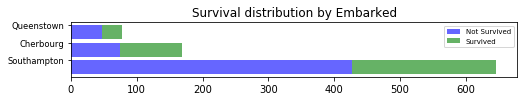

In [13]:
fig = plt.figure(figsize=(8, 1))
grouped = train.groupby(['Survived'])
group0 = grouped.get_group(0)
group1 = grouped.get_group(1)

ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan=2)
bottom = group0.EmbarkedInt.value_counts().index
width1 = group0.EmbarkedInt.value_counts()
plt.barh(bottom, width1, 0.8, 0.0, color='blue', label='Not Survived', alpha=0.6)
width2 = group1.EmbarkedInt.value_counts()
plt.barh(bottom, width2, 0.8, width1, color='green', label='Survived', alpha=0.6)
plt.legend(loc='best', fontsize='x-small')
ax1.set_yticks([0.4, 1.4, 2.4])
ax1.set_yticklabels(['Southampton', 'Cherbourg', 'Queenstown'], fontsize='small')
ax1.set_title('Survival distribution by Embarked')

In [14]:
title_to_int = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':1, 'Dr':4, 'Rev':4, 'Mlle':2, 'Major':4, 'Col':4,
        'Ms':3, 'Lady':3, 'the Countess':4, 'Sir':4, 'Mme':3, 'Capt':4, 'Jonkheer':4, 'Don':1, 'Dona':3}
train['TitleInt'] = train['Title'].map(title_to_int)
test['TitleInt'] = test['Title'].map(title_to_int)
train.loc[train[train['Age']<13].index, 'TitleInt'] = 5
test.loc[test[test['Age']<13].index, 'TitleInt'] = 5

train['FareCat'] = pd.cut(train['Fare'], [-0.1, 50, 100, 150, 200, 300, 1000], right=True, 
        labels=[0, 1, 2, 3, 4, 5])
test['FareCat'] = pd.cut(test['Fare'], [-0.1, 50, 100, 150, 200, 300, 1000], right=True, 
        labels=[0, 1, 2, 3, 4, 5])
train['AgeCat'] = pd.cut(train['Age'], [-0.1, 12.1, 20, 30, 35, 40, 45, 50, 55, 65, 100], right=True, 
        labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
test['AgeCat'] = pd.cut(test['Age'], [-0.1, 12.1, 20, 30, 35, 40, 45, 50, 55, 65, 100], right=True, 
        labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Text(0.5,1,'Survival distribution by Title')

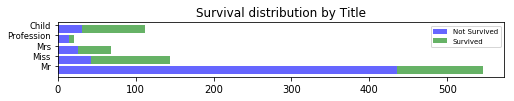

In [15]:
fig = plt.figure(figsize=(8, 1))
grouped = train.groupby(['Survived'])
group0 = grouped.get_group(0)
group1 = grouped.get_group(1)

ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan=2)
bottom = group0.TitleInt.value_counts().index
width1 = group0.TitleInt.value_counts()
plt.barh(bottom, width1, 0.8, 0.0, color='blue', label='Not Survived', alpha=0.6)
width2 = group1.TitleInt.value_counts()
plt.barh(bottom, width2, 0.8, width1, color='green', label='Survived', alpha=0.6)
plt.legend(loc='best', fontsize='x-small')
ax1.set_yticks([1.4, 2.4, 3.4, 4.4, 5.4])
ax1.set_yticklabels(['Mr', 'Miss', 'Mrs', 'Profession', 'Child'], fontsize='small')
ax1.set_title('Survival distribution by Title')

In [18]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
#columns = ['Pclass', 'SibSp', 'Parch', 'SexInt', 'EmbarkedInt', 'AgeCat', 'TitleInt', 'FareCat']
#columns = ['Pclass', 'SibSp', 'Parch', 'SexInt', 'EmbarkedInt', 'AgeInt', 'TitleInt', 'Fare']
#columns = ['Pclass', 'FamilySize', 'SexInt', 'EmbarkedInt', 'AgeCat', 'TitleInt', 'FareCat']
#columns = ['Pclass', 'FamilySize', 'SexInt', 'EmbarkedInt', 'AgeCat', 'TitleInt', 'FareCat',
#        'Friends', 'FriendsSex', 'FriendsSurvived']
#columns = ['Pclass', 'SibSp', 'Parch', 'SexInt', 'EmbarkedInt', 'AgeCat', 'TitleInt', 'FareCat',
#        'Friends', 'FriendsSex', 'FriendsSurvived', 'FatherSurvived', 'MotherSurvived', 'ChildSurvived']
#columns = ['Pclass', 'SibSp', 'Parch', 'SexInt', 'EmbarkedInt', 'AgeCat', 'TitleInt', 'FareCat']
#        'Friends', 'FriendsSex', 'FriendsSurvived']
#columns = ['Pclass', 'SexInt', 'EmbarkedInt', 'Age', 'TitleInt','Fare', 'Friends', 'FriendsSex', 'FriendsSurvived', 'FatherSurvived', 'MotherSurvived', 'ChildSurvived']
columns = ['Pclass', 'SexInt', 'EmbarkedInt', 'Age', 'TitleInt','Fare', 
        'Friends', 'Male_Friends_Survived', 'Male_Friends_NotSurvived', 'Female_Friends_Survived', 'Female_Friends_NotSurvived',
        'MotherOnBoard', 'MotherSurvived', 'ChildOnBoard', 'ChildSurvived', 'ChildNotSurvived']
X_train, X_test, y_train, y_test = train_test_split(train[columns], train['Survived'], test_size=0.2, random_state=123)

#Check the features importance. 
selected = SelectKBest(f_classif, 18)
selected.fit(X_train, y_train)
X_train_selected = selected.transform(X_train)
X_test_selected = selected.transform(X_test)
print(selected.scores_)
print(selected.pvalues_)

ValueError: k should be >=0, <= n_features; got 18.Use k='all' to return all features.

In [35]:
import warnings

warnings.simplefilter("ignore")


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [10, 50, 100, 150], 'min_samples_leaf': [1, 2, 4, 8], 
        'max_depth': [None, 5, 10, 50], 'max_features': [None, 'auto'], 'min_samples_split': [2, 4, 8]}
rfc = RandomForestClassifier(criterion='gini', min_weight_fraction_leaf=0.0, 
        max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False,
                             random_state=None, verbose=0, warm_start=False, class_weight=None)
classifer = GridSearchCV(rfc, param_grid, cv=5, n_jobs=6, verbose=1)
classifer.fit(X_train, y_train)
#print(classifer.grid_scores_)
print(classifer.best_params_)
print(X_train.info())

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=6)]: Done 273 tasks      | elapsed:    7.0s
[Parallel(n_jobs=6)]: Done 732 tasks      | elapsed:   17.3s
[Parallel(n_jobs=6)]: Done 1482 tasks      | elapsed:   34.3s


{'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 10}
<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 329 to 510
Data columns (total 16 columns):
Pclass                        712 non-null int64
SexInt                        712 non-null int64
EmbarkedInt                   712 non-null float64
Age                           712 non-null float64
TitleInt                      712 non-null int64
Fare                          712 non-null float64
Friends                       712 non-null int64
Male_Friends_Survived         712 non-null int64
Male_Friends_NotSurvived      712 non-null int64
Female_Friends_Survived       712 non-null int64
Female_Friends_NotSurvived    712 non-null int64
MotherOnBoard                 712 non-null int64
MotherSurvived                712 non-null int64
ChildOnBoard                  712 non-null int64
ChildSurvived                 712 non-null int64
ChildNotSurvived              712 non-null 

[Parallel(n_jobs=6)]: Done 1920 out of 1920 | elapsed:   44.5s finished


In [24]:
print(classifer.best_score_)

0.848314606741573


In [29]:
rfc = RandomForestClassifier(n_estimators=150, criterion='gini', max_depth=10, 
        min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
        max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, 
        oob_score=False, n_jobs=1, random_state=232, verbose=0, warm_start=False, class_weight=None)

rfc.fit(X_train, y_train)
result = rfc.predict(X_test)
rightnum = 0

for i in range(0, result.shape[0]):
    if result[i] == y_test.iloc[i]:
        rightnum += 1
print(rightnum/result.shape[0])


rfc.fit(train[columns], train['Survived'])
predict_rf = rfc.predict(test[columns])

submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predict_rf
    })
#submission.to_csv("titanic_predict_RF.csv", index=False)

0.88268156424581


In [27]:
import xgboost as xgb
xgbclassifer = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100, 
                                 silent=True, objective='binary:logistic',
                                 nthread=-1, gamma=0, min_child_weight=1,
                                 max_delta_step=0, subsample=1, colsample_bytree=1,
                                 colsample_bylevel=1, reg_alpha=0, reg_lambda=1,
                                 scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
xgbclassifer.fit(X_train, y_train)
result = xgbclassifer.predict(X_test)
#print(result[:10])
rightnum = 0
for i in range(0, result.shape[0]):
    if result[i] == y_test.iloc[i]:
        rightnum += 1
print(rightnum/result.shape[0])

xgbclassifer.fit(train[columns], train['Survived'])
predict_xgb = xgbclassifer.predict(test[columns])

submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predict_xgb
    })
#submission.to_csv("titanic_predict_xgb.csv", index=False)

0.88268156424581


In [28]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.regularizers import l2, l1
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X_train_scaled = stdScaler.fit_transform(X_train)
X_test_scaled = stdScaler.transform(X_test)
model = Sequential()
#model.add(Dense(700, input_dim=7, init='normal', activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1600, input_dim=16, init='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, init='normal', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop')
model.fit(X_train_scaled, y_train, nb_epoch=20, batch_size=32)
result = model.predict(X_test_scaled)
rightnum = 0
for i in range(0, result.shape[0]):
    if result[i] >= 0.5:
        result[i] = 1
    else:
        result[i] = 0
    if result[i] == y_test.iloc[i]:
        rightnum += 1
print(rightnum/result.shape[0])

train_scaled = stdScaler.fit_transform(train[columns])
test_scaled = stdScaler.transform(test[columns])
model.fit(train_scaled, train['Survived'], nb_epoch=20, batch_size=32, verbose=0)
predict_NN = model.predict(test_scaled)
print(predict_NN.shape)
for i in range(0, predict_NN.shape[0]):
    if predict_NN[i] >= 0.5:
        predict_NN[i] = 1
    else:
        predict_NN[i] = 0
        
predict_NN = predict_NN.reshape((predict_NN.shape[0]))
predict_NN = predict_NN.astype('int')
print(predict_NN.shape)
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predict_NN
    })
#submission.to_csv("titanic_predict_NN.csv", index=False)

Using TensorFlow backend.


Epoch 1/20
712/712 [==============================] - 1s 1ms/step - loss: 0.4840
Epoch 2/20
712/712 [==============================] - 0s 67us/step - loss: 0.4056
Epoch 3/20
712/712 [==============================] - 0s 65us/step - loss: 0.3951
Epoch 4/20
712/712 [==============================] - 0s 59us/step - loss: 0.3832
Epoch 5/20
712/712 [==============================] - 0s 56us/step - loss: 0.3759
Epoch 6/20
712/712 [==============================] - 0s 61us/step - loss: 0.3789
Epoch 7/20
712/712 [==============================] - 0s 56us/step - loss: 0.3627
Epoch 8/20
712/712 [==============================] - 0s 60us/step - loss: 0.3700
Epoch 9/20
712/712 [==============================] - 0s 59us/step - loss: 0.3710
Epoch 10/20
712/712 [==============================] - 0s 62us/step - loss: 0.3561
Epoch 11/20
712/712 [==============================] - 0s 60us/step - loss: 0.3461
Epoch 12/20
712/712 [==============================] - 0s 58us/step - loss: 0.3605
Epoch 13/20
71

In [26]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
result = clf.predict(X_test)
rightnum = 0
for i in range(0, result.shape[0]):
    if result[i] == y_test.iloc[i]:
        rightnum += 1
print(rightnum/result.shape[0])

predict_svm = clf.predict(test[columns])

0.7150837988826816


In [30]:
from deap import gp
import itertools
import operator
import math
import numpy as np

train_GP = train[columns]
test_GP = test[columns]
train_GP = train_GP.astype('float')
test_GP = test_GP.astype('float')

pset = gp.PrimitiveSetTyped("MAIN", itertools.repeat(float, 16), float, "IN")

pset.addPrimitive(operator.and_, [bool, bool], bool)
pset.addPrimitive(operator.or_, [bool, bool], bool)
pset.addPrimitive(operator.not_, [bool], bool)

# Define a protected division function
def protectedDiv(left, right):
    if right != 0.0:
        return left/right
    else:
        return 1
def protectedSqrt(x):
    return math.sqrt(abs(x))
pset.addPrimitive(operator.add, [float,float], float)
pset.addPrimitive(operator.sub, [float,float], float)
pset.addPrimitive(operator.mul, [float,float], float)
pset.addPrimitive(protectedDiv, [float,float], float)
pset.addPrimitive(math.sin, [float], float)
pset.addPrimitive(math.cos, [float], float)
pset.addPrimitive(math.tanh, [float], float)
pset.addPrimitive(math.hypot, [float, float], float)
pset.addPrimitive(max, [float, float], float)
pset.addPrimitive(min, [float, float], float)
pset.addPrimitive(protectedSqrt, [float], float)

# Define a new if-then-else function
def if_then_else(input, output1, output2):
    if input: return output1
    else: return output2

pset.addPrimitive(operator.lt, [float, float], bool)
pset.addPrimitive(operator.eq, [float, float], bool)
pset.addPrimitive(if_then_else, [bool, float, float], float)

expr = 'sub(min(add(cos(cos(mul(8.791524057280029, add(0.8813426844222205, IN2)))), \
protectedDiv(sub(protectedDiv(IN14, IN10), IN11), protectedSqrt(sub(protectedDiv\
(hypot(protectedDiv(if_then_else(or_(True, and_(or_(True, True), True)), IN9, \
add(protectedDiv(protectedDiv(0.9363229575602429, 9.457393756367038), 68.60931271115085),\
sub(0.76609748747378, IN15))), 9.457393756367038), sin(0.22806884104520364)), \
if_then_else(or_(lt(protectedDiv(if_then_else(True, IN2, IN4), protectedDiv\
(hypot(0.8201212481183877, 81.83905300378048), IN0)), IN5), or_(True, True)), IN9,\
cos(mul(0.7027184429804209, add(protectedDiv(protectedDiv(0.9363229575602429, \
9.457393756367038), 9.457393756367038), sub(if_then_else(or_(False, True), cos\
(0.23992695841396383), hypot(2.718281828459045, IN12)), IN15)))))), IN12)))), \
hypot(IN4, tanh(protectedSqrt(max(protectedDiv(hypot(add(0.9095718824824596, \
360.49409062712783), sin(IN9)), min(mul(97.97893140946204, protectedDiv(IN0, \
0.3160036101933281)), protectedDiv(protectedDiv(if_then_else(or_(True, True), \
IN9, cos(mul(8.791524057280029, add(protectedDiv(IN9, 9.457393756367038), \
sub(add(IN9, 31.792888528447644), IN15))))), 9.457393756367038), 2.0803290751797636))), \
protectedSqrt(cos(mul(8.791524057280029, IN6)))))))), min(protectedSqrt(max\
(protectedDiv(5.010370880110474, protectedDiv(IN15, add(336.6490971360746, \
protectedDiv(sub(if_then_else(True, max(IN3, IN5), cos(sin(0.22806884104520364))), \
hypot(sin(add(add(mul(tanh(max(IN4, 95.88858811362302)), 235.99768570024435), \
2.0803290751797636),sin(sub(protectedDiv(IN0, 0.3160036101933281), 0.9466582602925034)))), \
add(cos(add(49.46712430568304, 4.937708033384823)), protectedDiv(mul(97.97893140946204, \
protectedDiv(IN0, 0.3160036101933281)), protectedSqrt(max(protectedDiv(IN3, IN1),\
 if_then_else(True, protectedSqrt(0.8174130427244765), 0.7377841058934647))))))), \
 if_then_else(or_(and_(or_(or_(False, False), False), True), True), sub(IN14, \
 0.22806884104520364), IN9))))), protectedSqrt(max(protectedDiv(IN3, IN1), \
 cos(546.215547398933))))), IN3))'
gpfunc = gp.compile(expr, pset)

def output(x):
    try:
        return int(round(1.0/(1.0 + math.exp(-x))))
    except(OverflowError):
        return 0
    
predict_GP = np.zeros((test.shape[0]))
for i in range (0, test.shape[0]):
    predict_GP[i] = output(gpfunc(*test[columns].iloc[i, :]))
predict_GP = predict_GP.astype('int')
submission = pd.DataFrame({"PassengerId": test["PassengerId"], "Survived": predict_GP})
#submission.to_csv("titanic_predict_gp.csv", index=False)

In [31]:
predict_combine = np.zeros((test.shape[0]))
for i in range(0, test.shape[0]):
    temp = predict_rf[i] + predict_NN[i] + predict_GP[i]
    if temp>=2:
        predict_combine[i] = 1
predict_combine = predict_combine.astype('int')

combination = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predict_combine
    })
#combination.to_csv("titanic_predict_combine.csv", index=False)

----
----
----
----

# original

https://www.kaggle.com/masumrumi/a-statistical-analysis-of-titanic-with-ml-models

# points


 